In [1]:
print ('Hello I am Sayan Ray and in this part we are going to implement a Lissajus figure for a follower robot')

Hello I am Sayan Ray and in this part we are going to implement a Lissajus figure for a follower robot


In [2]:
import rospy
import numpy as np
import math as mt
from nav_msgs.msg import Odometry
from tf.transformations import euler_from_quaternion
from geometry_msgs.msg import Point, Twist
from math import atan2
import matplotlib.pyplot as plt

#these variable store the bot's current coordinates and heading
x = 0.0
y = 0.0 
theta = 0.0


def newOdom(msg):
    global x
    global y
    global theta

    x = msg.pose.pose.position.x
    y = msg.pose.pose.position.y

    rot_q = msg.pose.pose.orientation
    (roll, pitch, theta) = euler_from_quaternion([rot_q.x, rot_q.y, rot_q.z, rot_q.w])
    
    

rospy.init_node("speed_controller")

sub = rospy.Subscriber("/odom", Odometry, newOdom)
pub = rospy.Publisher("/cmd_vel", Twist, queue_size = 1)

speed = Twist()

# setting the rate to 5 times per second
r = rospy.Rate(5)

# this is the target points where the robot is supposed to move to
goal = Point()
goal.x = 0
goal.y = 0

#these lists will store the current coordinates of the robot
xco = [0]
yco = [0]

#these lists will store the target or goal coordinated of the robot
finx = [0]
finy = [0]

# this list stores the time in realtime
tim = [0]

# these lists store the error values for the parameters of x, y and heading top to bottom respectively
erx = [0]
ery = [0]
ert = [0]

#these liste store the linear and angular velocities
linVeltr = [0]
angVeltr = [0]
linVelrf = [0]
angVelrf = [0]

# c is the variable that stores the curren time in seconds
c = 0.0

# this is a constant, unchangeable represents the sampling interval
h = 0.2

# Now the gains for our model
Ka = 3
Kv = 3

# this is the heading rate variable
alpha_dot = 0

# Now the gains for the follower robot controller
K1 = 1
K2 = 2
K3 = 2

#just storing the pi value in a variable
pai = mt.pi

# this variable simply serves as an indexing variable fot the lists
k = 0

while not rospy.is_shutdown():

    #this is just for printing the curve tracking performances
    if (c>=140.0):
        break
        
    # Setting the goalpoints as the points on the lissajous curve
    goal.x = 3 * mt.sin(0.15*c)
    goal.y = 3 * mt.sin(0.1*c)
    
    # the error terms are given as
    err_x = goal.x - x
    err_y = goal.y - y
    
    # Corrosponding to that the parameters are:
    
    dis_er=(err_x**2+err_y**2) **0.5    # distance error
    angle_goal = mt.atan2(err_y, err_x) # reference heading
    angle_err = angle_goal - theta      # heading error (reference heading - current heading)
    
    #this section is to make sure the angle_err is within the range -pi to +pi
    if (angle_err <= -pai): 
        angle_err = angle_err + 2*pai
    
    if (angle_err > pai):
        angle_err = angle_err - 2*pai
    
           
    # the indexing variable is now set
    k=int(c * 5)
    
    # determining the heading rate value
    if (goal.x==0 and goal.y==0):
        heading_rate = 0
    else:
        deno = ((goal.x)**2 + (goal.y)**2) * h
        y_diff = finy[k] - finy[k-1] 
        x_diff = finx[k] - finx[k-1]
        heading_rate = (finx[k]*y_diff - finy[k]*x_diff)/deno
    
    # Thus the respective linear and angular velocities of the reference robot 
    ref_lin_vel = Kv * dis_er * mt.cos(angle_err) 
    ref_ang_vel = Ka * angle_err + heading_rate
    
    #the start
    z1 = -1 * err_x
    z2 = -1 * err_y 
    z3 = -1 * mt.tan(angle_err)
    
    tra_lin_vel = ref_lin_vel - K1 * abs(ref_lin_vel) * z1
    tra_ang_vel = ref_ang_vel - K2 * ref_lin_vel * z2 - K3 * abs(ref_lin_vel) * z3
    
    # Sending the values to the robot
    speed.linear.x  = tra_lin_vel
    speed.angular.z = tra_ang_vel
    
    # storing the follower's current coordinates
    xco.append(x)
    yco.append(y)    
    # storing the goal coordinates
    finx.append(goal.x)
    finy.append(goal.y)
    # storing the time
    tim.append(c)
    # storing the errors
    erx.append(err_x)
    ery.append(err_y)
    ert.append(angle_err)
    linVeltr.append(tra_lin_vel)
    angVeltr.append(tra_ang_vel)
    linVelrf.append(ref_lin_vel)
    angVelrf.append(ref_ang_vel)
    # time update
    c = c + 0.2

    pub.publish(speed)
    r.sleep()

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


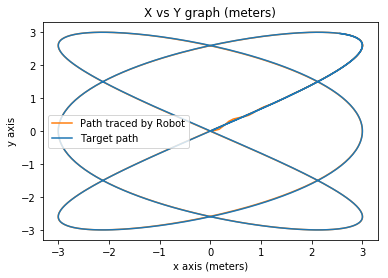

In [3]:
plt.plot(xco, yco, color ='tab:orange',label = "Path traced by Robot")
plt.plot(finx, finy, color ='tab:blue',label = "Target path")

# naming the x axis
plt.xlabel('x axis (meters)')

# naming the y axis
plt.ylabel('y axis')
 
# giving a title to my graph
plt.title('X vs Y graph (meters)')
 
# function to show the plot
plt.legend()
plt.show()

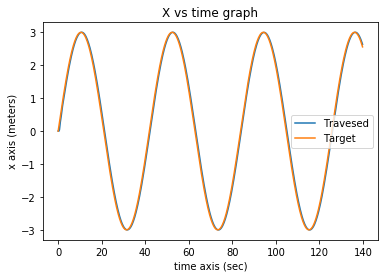

In [4]:
plt.plot(tim, xco, color ='tab:blue',label = "Travesed")
plt.plot(tim, finx, color ='tab:orange',label = "Target")

# naming the axes
plt.xlabel('time axis (sec)')
plt.ylabel('x axis (meters)')
 
# title of graph
plt.title('X vs time graph')

plt.legend()
plt.show()

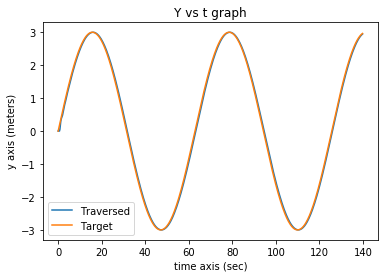

In [5]:
plt.plot(tim, yco, color ='tab:blue',label = "Traversed")
plt.plot(tim, finy, color ='tab:orange',label = "Target")

# naming the axes
plt.xlabel('time axis (sec)')
plt.ylabel('y axis (meters)')
 
# title of graph
plt.title('Y vs t graph')

plt.legend()
plt.show()

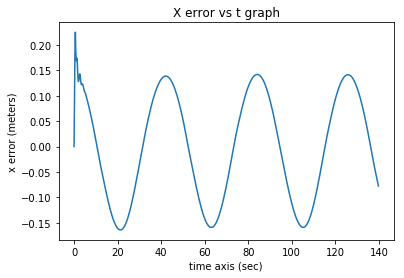

('The RMSE of x error is (in meters) :', '0.105437516464')


In [6]:
plt.plot(tim, erx, color ='tab:blue')

# naming the axes
plt.xlabel('time axis (sec)')
plt.ylabel('x error (meters)')
 
# title of graph
plt.title('X error vs t graph')
 
plt.show()
print("The RMSE of x error is (in meters) :",str(mt.sqrt(np.mean(np.square(erx)))))

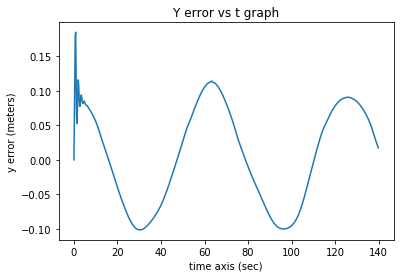

('The RMSE of y error is (in meters) :', '0.0717336262471')


In [7]:
plt.plot(tim, ery, color ='tab:blue')

# naming the axes
plt.xlabel('time axis (sec)')
plt.ylabel('y error (meters)')
 
# title of graph
plt.title('Y error vs t graph')

plt.show()
print("The RMSE of y error is (in meters) :",str(mt.sqrt(np.mean(np.square(ery)))))

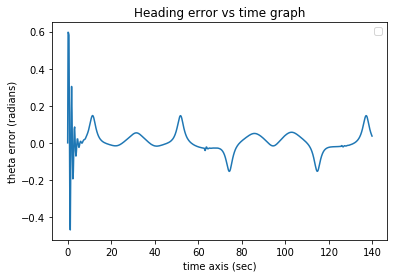

('The RMSE of heading error is (in meters) :', '0.0704364130394')


In [8]:
plt.plot(tim, ert, color ='tab:blue')

# naming the axes
plt.xlabel('time axis (sec)')
plt.ylabel('theta error (radians)')
 
# title of graph
plt.title('Heading error vs time graph')

plt.legend()
plt.show()
print("The RMSE of heading error is (in meters) :",str(mt.sqrt(np.mean(np.square(ert)))))

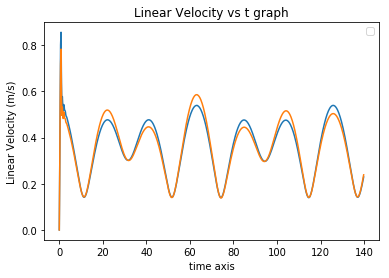

In [9]:
plt.plot(tim, linVeltr, color ='tab:blue')
plt.plot(tim, linVelrf, color ='tab:orange')
# naming the axes
plt.xlabel('time axis')
plt.ylabel('Linear Velocity (m/s)')
 
# title of graph
plt.title('Linear Velocity vs t graph')

plt.legend()
plt.show()


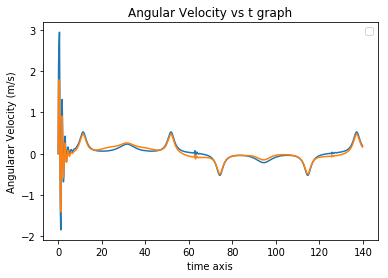

In [10]:
plt.plot(tim, angVeltr, color ='tab:blue')
plt.plot(tim, angVelrf, color ='tab:orange')
# naming the axes
plt.xlabel('time axis')
plt.ylabel('Angularar Velocity (m/s)')
 
# title of graph
plt.title('Angular Velocity vs t graph')

plt.legend()
plt.show()

speed.linear.x  = 0
speed.angular.z = 0
quit()